# Atmospherically Corrected Earth Engine Time Series 

### Overview

This notebook creates atmospherically corrected time series of satellite imagery using [Google Earth Engine](https://earthengine.google.com/) and the [6S emulator](https://github.com/samsammurphy/6S_emulator). 

### Supported missions

* Sentintel2
* Landsat8
* Landsat7
* Landsat5
* Landsat4

### Output

Average, cloud-*free* pixel values 

### Cloud masking

Uses standard cloud masks, i.e. FMASK for Landsat and ESA-QA60 for Sentinel 2.  There is no guarantee they will find all clouds, a discussion on more advance and/or alternative cloud masking strategies is available [here](https://groups.google.com/forum/#!searchin/google-earth-engine-developers/cloud$20AND$20sentinel2%7Csort:relevance/google-earth-engine-developers/i63DS-Dg8Sg/FWenONUFBwAJ)

____

### Initialize

In [1]:
# standard modules
import os
import sys
import ee
import matplotlib
import pandas as pd
from IPython.display import display, Image
%matplotlib notebook 
ee.Initialize()

# custom modules
base_dir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(base_dir,'atmcorr'))
from kml_reader import read_kml
from ee_requests import request_meanRadiance
from data_extraction import *

from timeSeries import timeSeries
from postProcessing import postProcessing
from plots import *


In [2]:
#debuggin
%load_ext autoreload
%autoreload 2

### User Input

In [3]:
target = 'Lake Nyos'

# geometry
geom = read_kml(target, kmlFile='RED_LAKES.kml')

# start and end of time series
startDate = '1985-01-01'# YYYY-MM-DD
stopDate  = '2018-01-01'# YYYY-MM-DD

# satellite missions
missions = ['Sentinel2', 'Landsat8', 'Landsat7', 'Landsat5', 'Landsat4']

### Google Earth Engine TimeSeries

We need to extract data from Earth Engine so that we can process it locally. The following code gets the mean average radiance through time from inside the geometry defined above (clouds are masked by default). 

It also grabs the inputs required for atmospheric correction (e.g. aerosol optical thickness, water vapor, etc.).

#### Earth Engine Requests
Let's set up some requests for Earth Engine data.

In [4]:
requests = {}

for mission in missions:
    requests[mission] = request_meanRadiance(geom, startDate, stopDate, mission, True)

There are two methods for  accessing this data locally.

1. getInfo
2. export 

**getInfo()** is easier for humans, we will try that first.<br>
**export** can handle larger requests (it is our backup plan).

In [5]:
from data_extraction import data_extractor

data = data_extractor(target, requests, method='excel')

Loading from excel file


### Atmospherically correct the data

In [6]:
from atmospheric_correction import run_atmcorr
data = run_atmcorr(data)

Surface reflectance already calculated
if override required --> data = run_atmcorr(data, force=True)


### Color Space

The hue-saturation-value color space is added to the dataset

In [7]:
# red-green-blue
rgb = list(zip(data['red'], data['green'], data['blue']))

# hue-staturation-value
hsv = [colorsys.rgb_to_hsv(x[0], x[1], x[2]) for x in rgb]

data['hue'] = [x[0] for x in hsv]
data['sat'] = [x[1] for x in hsv]
data['val'] = [x[2] for x in hsv]

### Save post-processing to excel

In [8]:
save_to_excel(data, target)

### Time Series Plots

In [9]:
from plots import Plot
plot = Plot(data, '1985-01-01','2017-01-01')

<IPython.core.display.Javascript object>


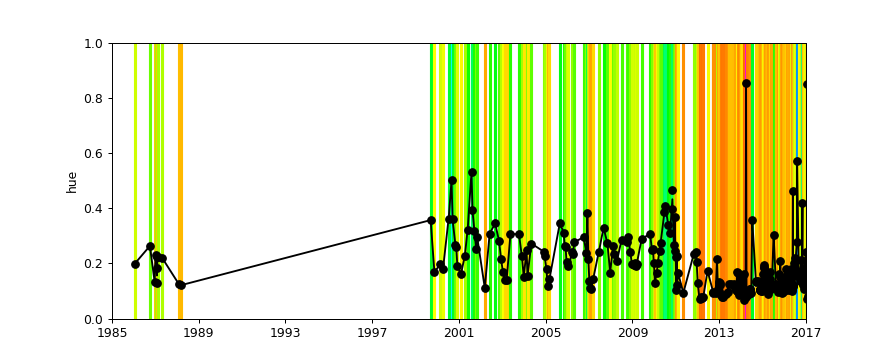

In [10]:
plot.hue()

In [11]:
# plot.graph('sat')

In [12]:
# plot.graph('val')

In [13]:
from image_viewer import *
region = view_window(geom)

In [14]:
date = '2013-12-27'

In [15]:
rgb = surface_reflectance_inspector(data, date=date, bands = ['red', 'green', 'blue'])
purehue = rgb_to_pureHue(rgb)

jupyter_img1 = Image(url=rgb.getThumbUrl({
                'region':region,
                'min':0,
                'max':0.3
                }))

jupyter_img2 = Image(url=purehue.getThumbUrl({
                'region':region,
                'min':0,
                'max':1
                }))

display(jupyter_img1, jupyter_img2)

scene datetime: 2013-12-31 09:33:50.313000
fileID: LC81860562013365LGN00
